In [8]:
import pickle 
import glob
import os

In [ ]:
PICKLE_DIR = "genomes_to_annotate_with_PlasmoFP/with_PFP_predictions_complete_2"
gene_dicts = {}
for pkl in glob.glob(f"{PICKLE_DIR}/*_gene_dict_with_PFP.pkl"):
    key = os.path.basename(pkl).split("_gene_dict")[0]
    with open(pkl, "rb") as f:
        gene_dicts[key] = pickle.load(f)

In [44]:
gene_dicts.keys()

dict_keys(['PlasmoDB-68_PinuiSanAntonio1', 'PlasmoDB-68_PovalewallikeriPowCR01', 'PlasmoDB-68_PreichenowiCDC', 'PlasmoDB-68_Pfalciparum3D7', 'PlasmoDB-68_Pchabaudichabaudi', 'PlasmoDB-68_PfragileNilgiri', 'PlasmoDB-68_PblacklockiG01', 'PlasmoDB-68_PvivaxSal1', 'PlasmoDB-68_PcynomolgiM', 'PlasmoDB-68_PgaboniG01', 'PlasmoDB-68_Pyoeliiyoelii17XNL2023', 'PlasmoDB-68_PovalecurtisiGH01', 'PlasmoDB-68_PmalariaeUG01', 'PlasmoDB-68_PbergheiANKA', 'PlasmoDB-68_Pgallinaceum8A', 'PlasmoDB-68_PcoatneyiHackeri', 'PlasmoDB-68_PknowlesiH', 'PlasmoDB-68_PadleriG01', 'PlasmoDB-68_PvinckeibrucechwattiDA'])

In [ ]:
curated_keys = [
    ('GO Function', 'GO IEA Function'),
    ('GO Process', 'GO IEA Process'),
    ('GO Component', 'GO IEA Component'),
]

pfp_keys = {
    'MF': 'PFP MF',
    'BP': 'PFP BP',
    'CC': 'PFP CC'
}
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]

records = []

for species, genes in gene_dicts.items():
    curated_counts = {'species': species}
    curated_stats = {'unannotated': 0, 'partially_annotated': 0, 'fully_annotated': 0}
    
    threshold_stats = {
        t: {'unannotated': 0, 'partially_annotated': 0, 'fully_annotated': 0}
        for t in thresholds
    }
    
    for gene_id, annot in genes.items():
        curated_presence = []
        for non_iea_key, iea_key in curated_keys:
            non_iea = annot.get(non_iea_key, [])
            iea = annot.get(iea_key, [])
            curated_presence.append(bool(non_iea or iea))
        
        if not any(curated_presence):
            curated_stats['unannotated'] += 1
        elif all(curated_presence):
            curated_stats['fully_annotated'] += 1
        else:
            curated_stats['partially_annotated'] += 1
        
        # Include PFP predictions at each threshold
        for t in thresholds:
            pfp_presence = []
            for ont, pfp_key in pfp_keys.items():
                curated_any = curated_presence[['MF','BP','CC'].index(ont)]
                pfp_dict = annot.get(pfp_key, {})
                preds = pfp_dict.get(t, set())
                pfp_presence.append(bool(curated_any or preds))
            
            if not any(pfp_presence):
                threshold_stats[t]['unannotated'] += 1
            elif all(pfp_presence):
                threshold_stats[t]['fully_annotated'] += 1
            else:
                threshold_stats[t]['partially_annotated'] += 1
    
    row = {
        'species': species,
        'threshold': 'curated_only',
        **curated_stats
    }
    records.append(row)
    for t, stats in threshold_stats.items():
        row = {
            'species': species,
            'threshold': t,
            **stats
        }
        records.append(row)

df = pd.DataFrame(records)
df = df.set_index(['species', 'threshold'])


In [47]:
df.to_csv("genomes_to_annotate_with_PlasmoFP/gene_annotation_stats_with_PlasmoFP.csv")

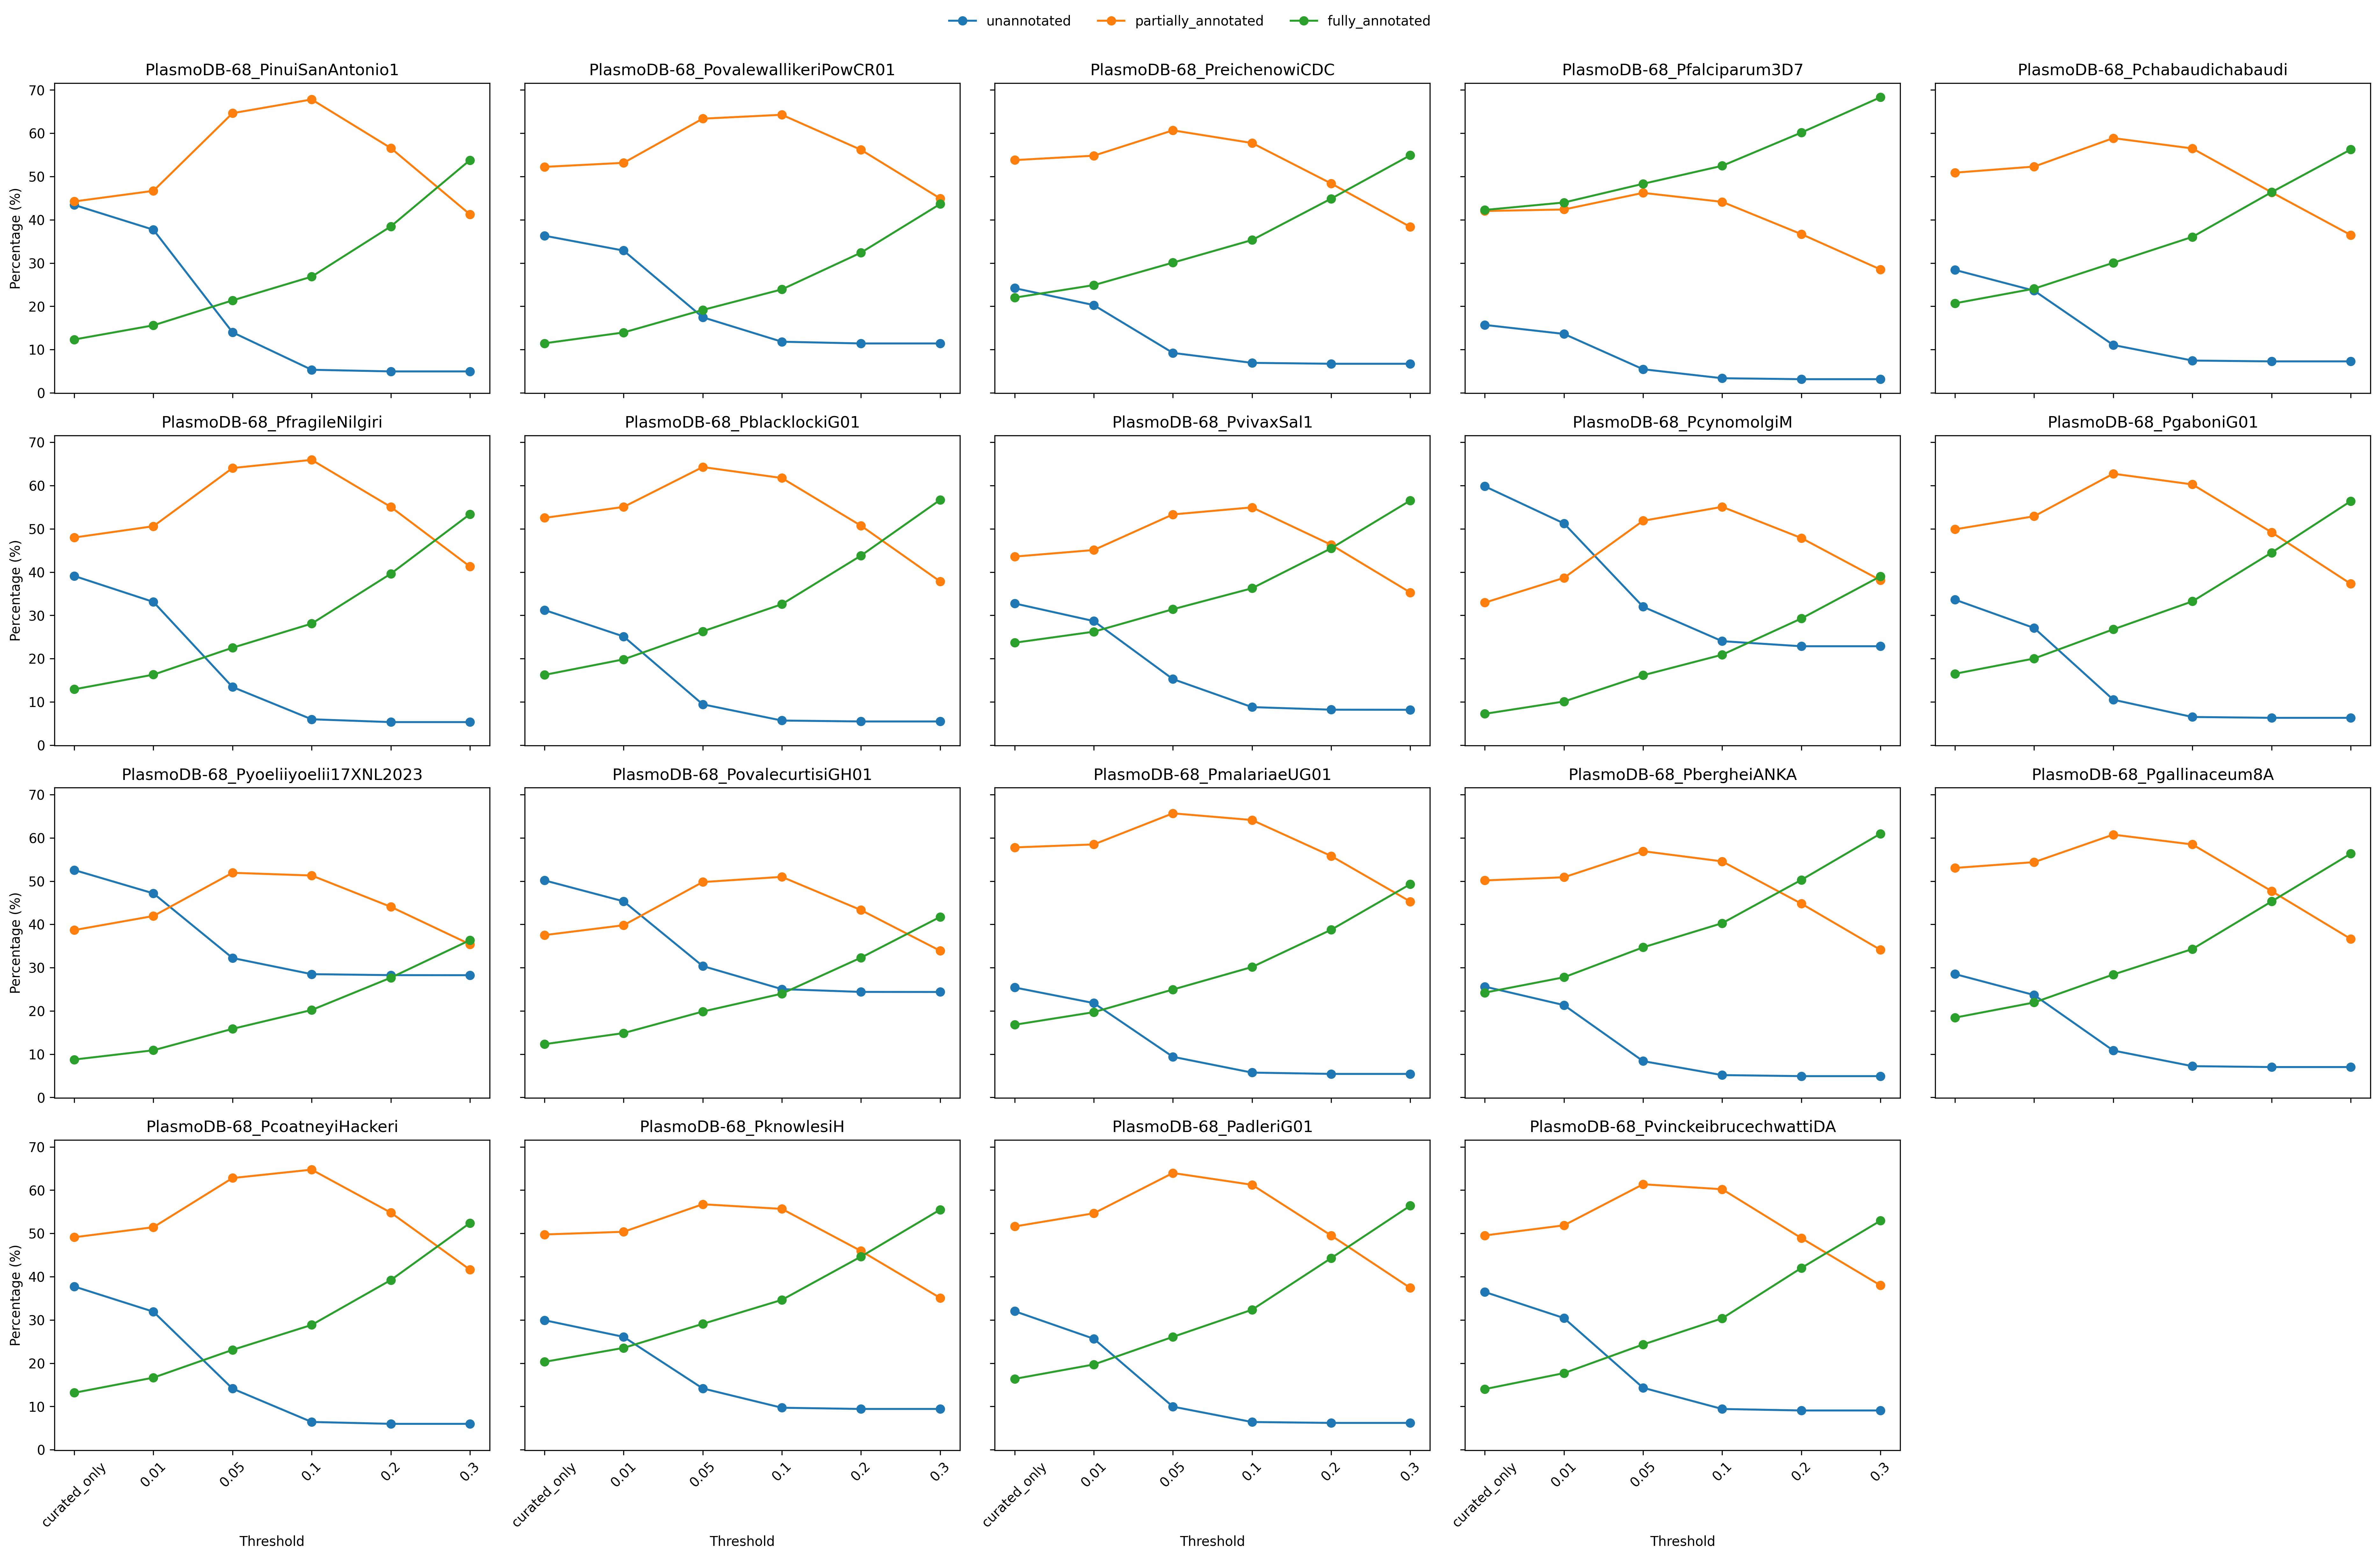

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

species_list = df.index.get_level_values('species').unique()
n = len(species_list)
cols = 5
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4),
                         sharex=True, sharey=True, squeeze=False)
fig.dpi = 300
def sort_key(t):
    return -1 if t=='curated_only' else float(t)

for ax, sp in zip(axes.flatten(), species_list):
    sub = df.xs(sp).reset_index()
    sub['order'] = sub['threshold'].apply(sort_key)
    sub = sub.sort_values('order')
    
    counts = sub[['unannotated','partially_annotated','fully_annotated']]
    pct = counts.div(counts.sum(axis=1), axis=0) * 100
    
    x = np.arange(len(sub))
    labels = sub['threshold'].astype(str)
    for col in pct.columns:
        ax.plot(x, pct[col], marker='o', label=col)
    
    ax.set_title(sp)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)

for ax in axes[-1]:  # bottom row
    ax.set_xlabel('Threshold')
for ax in axes[:,0]:  # left column
    ax.set_ylabel('Percentage (%)')

for ax in axes.flatten()[n:]:
    ax.set_visible(False)
handles, labels = axes.flatten()[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='upper center',        # place at top center
    ncol=len(labels),          # one column per category
    frameon=False,             # no box around it
    bbox_to_anchor=(0.5, 1.02) # slightly above the figure
)

fig.tight_layout(rect=[0, 0, 1, 0.99])  # leave space at top for legend
plt.show()
fig.tight_layout()
plt.show()


In [ ]:
species_to_name = {'PlasmoDB-68_PadleriG01': 'P. adleri',
             'PlasmoDB-68_PbergheiANKA': 'P. berghei',
             'PlasmoDB-68_PblacklockiG01': 'P. blacklocki',
             'PlasmoDB-68_Pchabaudichabaudi': 'P. chabaudi',
             'PlasmoDB-68_PcoatneyiHackeri': 'P. coatneyi',
             'PlasmoDB-68_PcynomolgiM': 'P. cynomolgi',
             'PlasmoDB-68_Pfalciparum3D7': 'P. falciparum',
             'PlasmoDB-68_PfragileNilgiri': 'P. fragile',
             'PlasmoDB-68_PgaboniG01': 'P. gaboni',
             'PlasmoDB-68_Pgallinaceum8A': 'P. gallinaceum',
             'PlasmoDB-68_PinuiSanAntonio1': 'P. inui',
             'PlasmoDB-68_PknowlesiH': 'P. knowlesi',
             'PlasmoDB-68_PmalariaeUG01': 'P. malariae',
             'PlasmoDB-68_PovalecurtisiGH01': 'P. ovale curtisi',
             'PlasmoDB-68_PovalewallikeriPowCR01': 'P. ovale wallikeri',
             'PlasmoDB-68_PreichenowiCDC': 'P. reichenowi',
             'PlasmoDB-68_PvinckeibrucechwattiDA': 'P. vinckei',
             'PlasmoDB-68_PvivaxP01': 'P. vivax P01',
             'PlasmoDB-68_PvivaxSal1': 'P. vivax',
             'PlasmoDB-68_Pyoeliiyoelii17XNL2023': 'P. yoelii'}

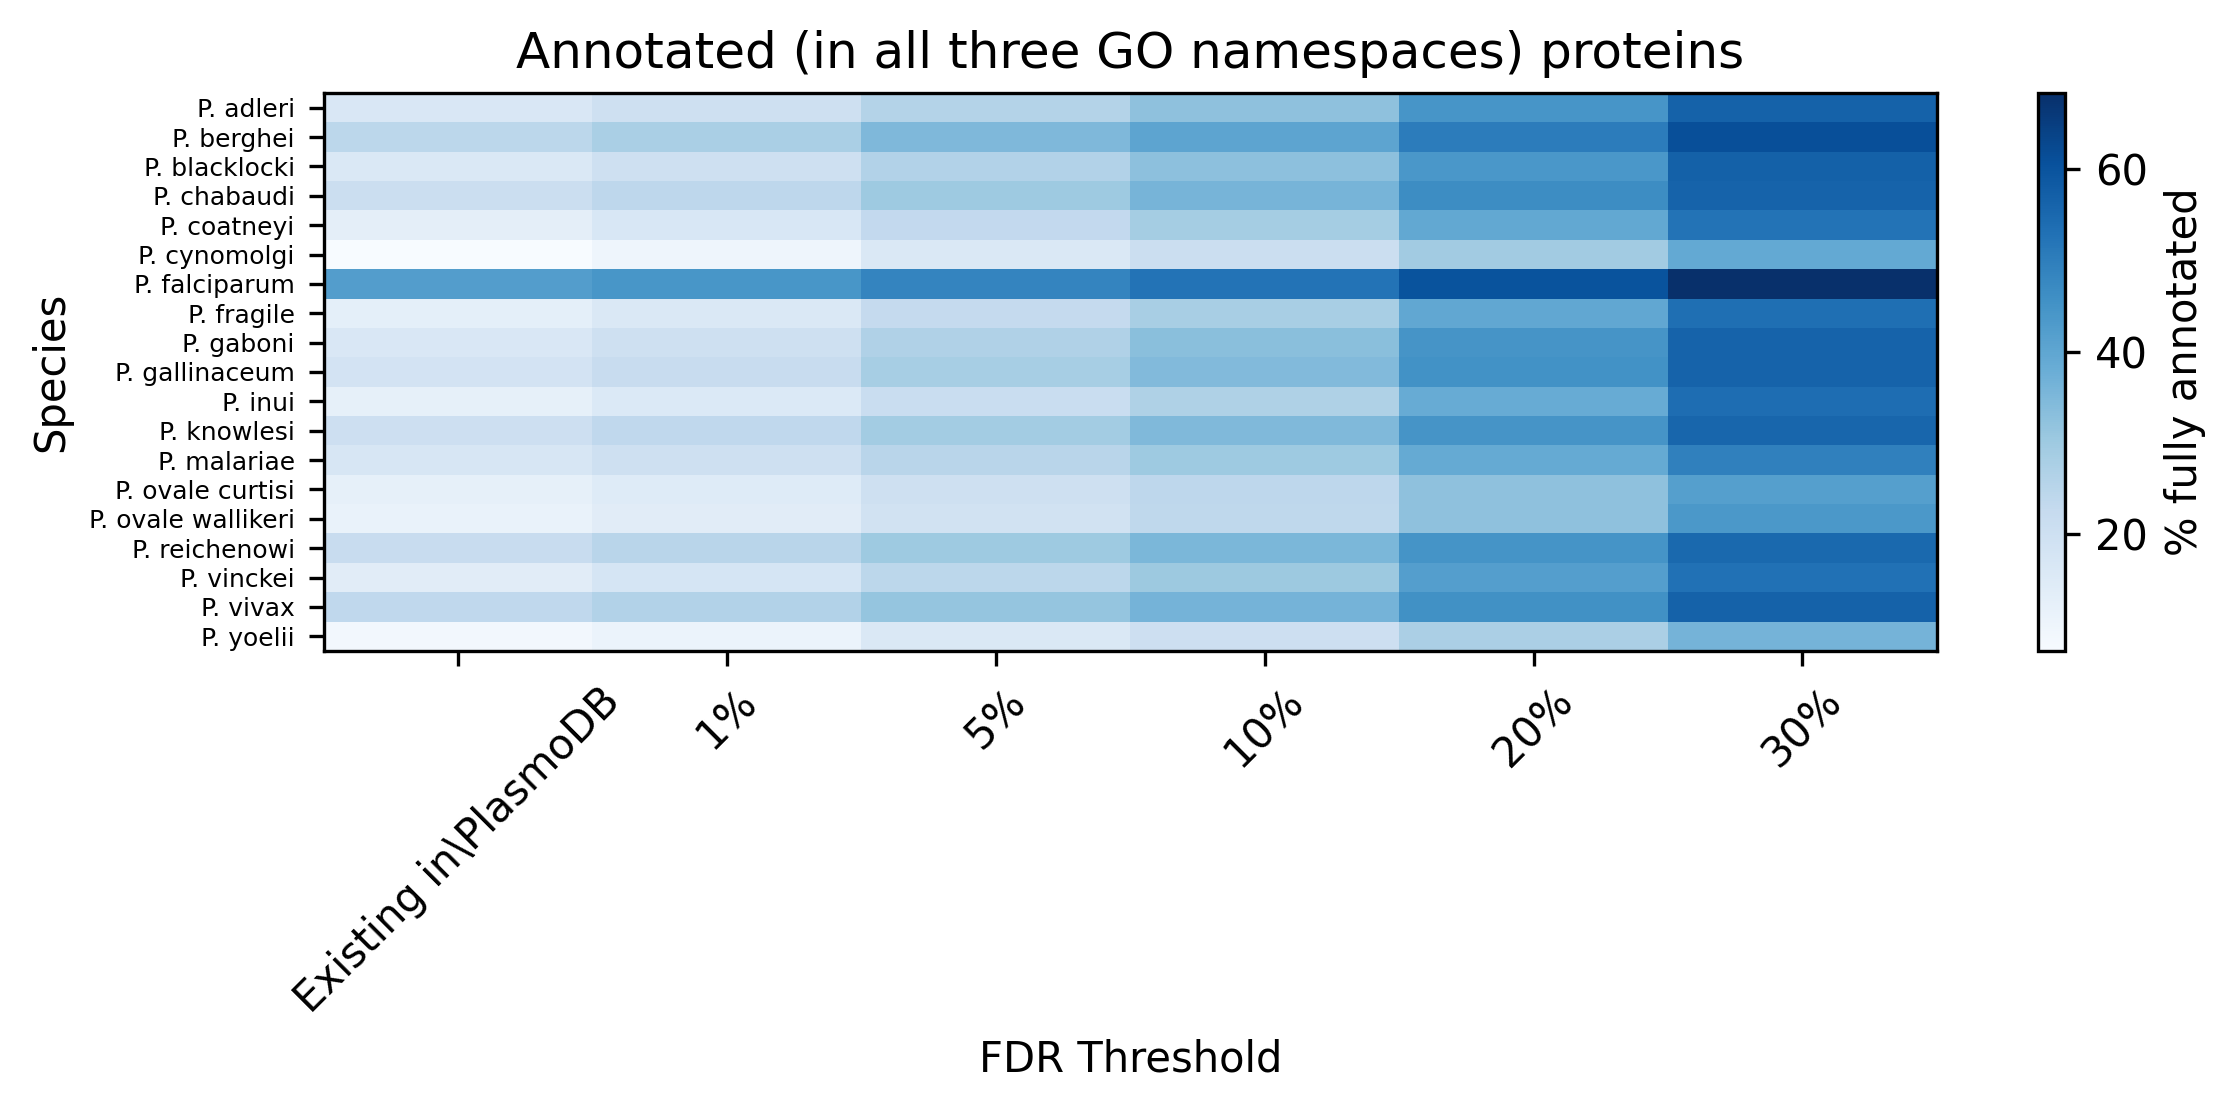

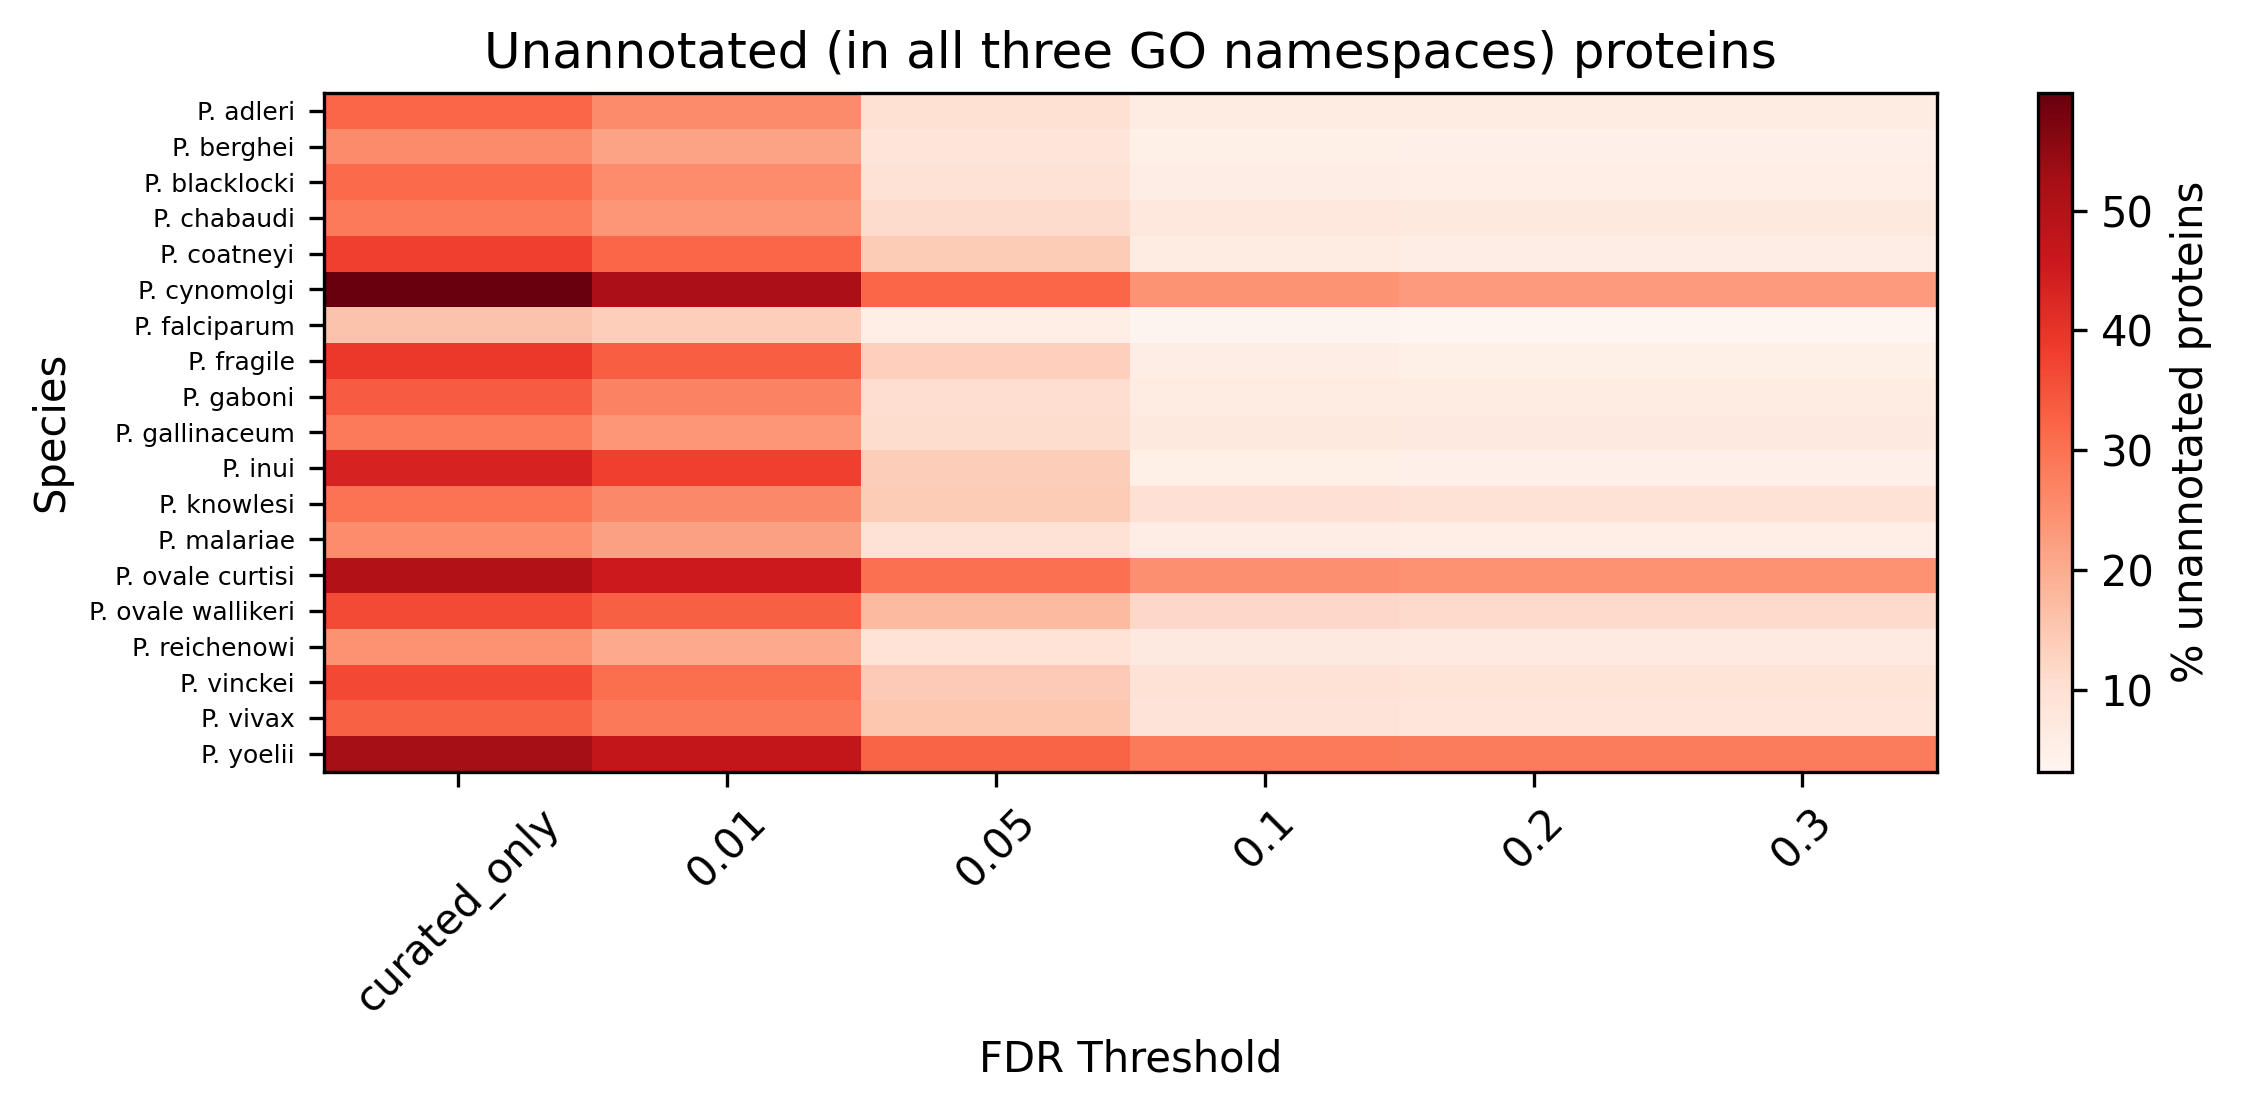

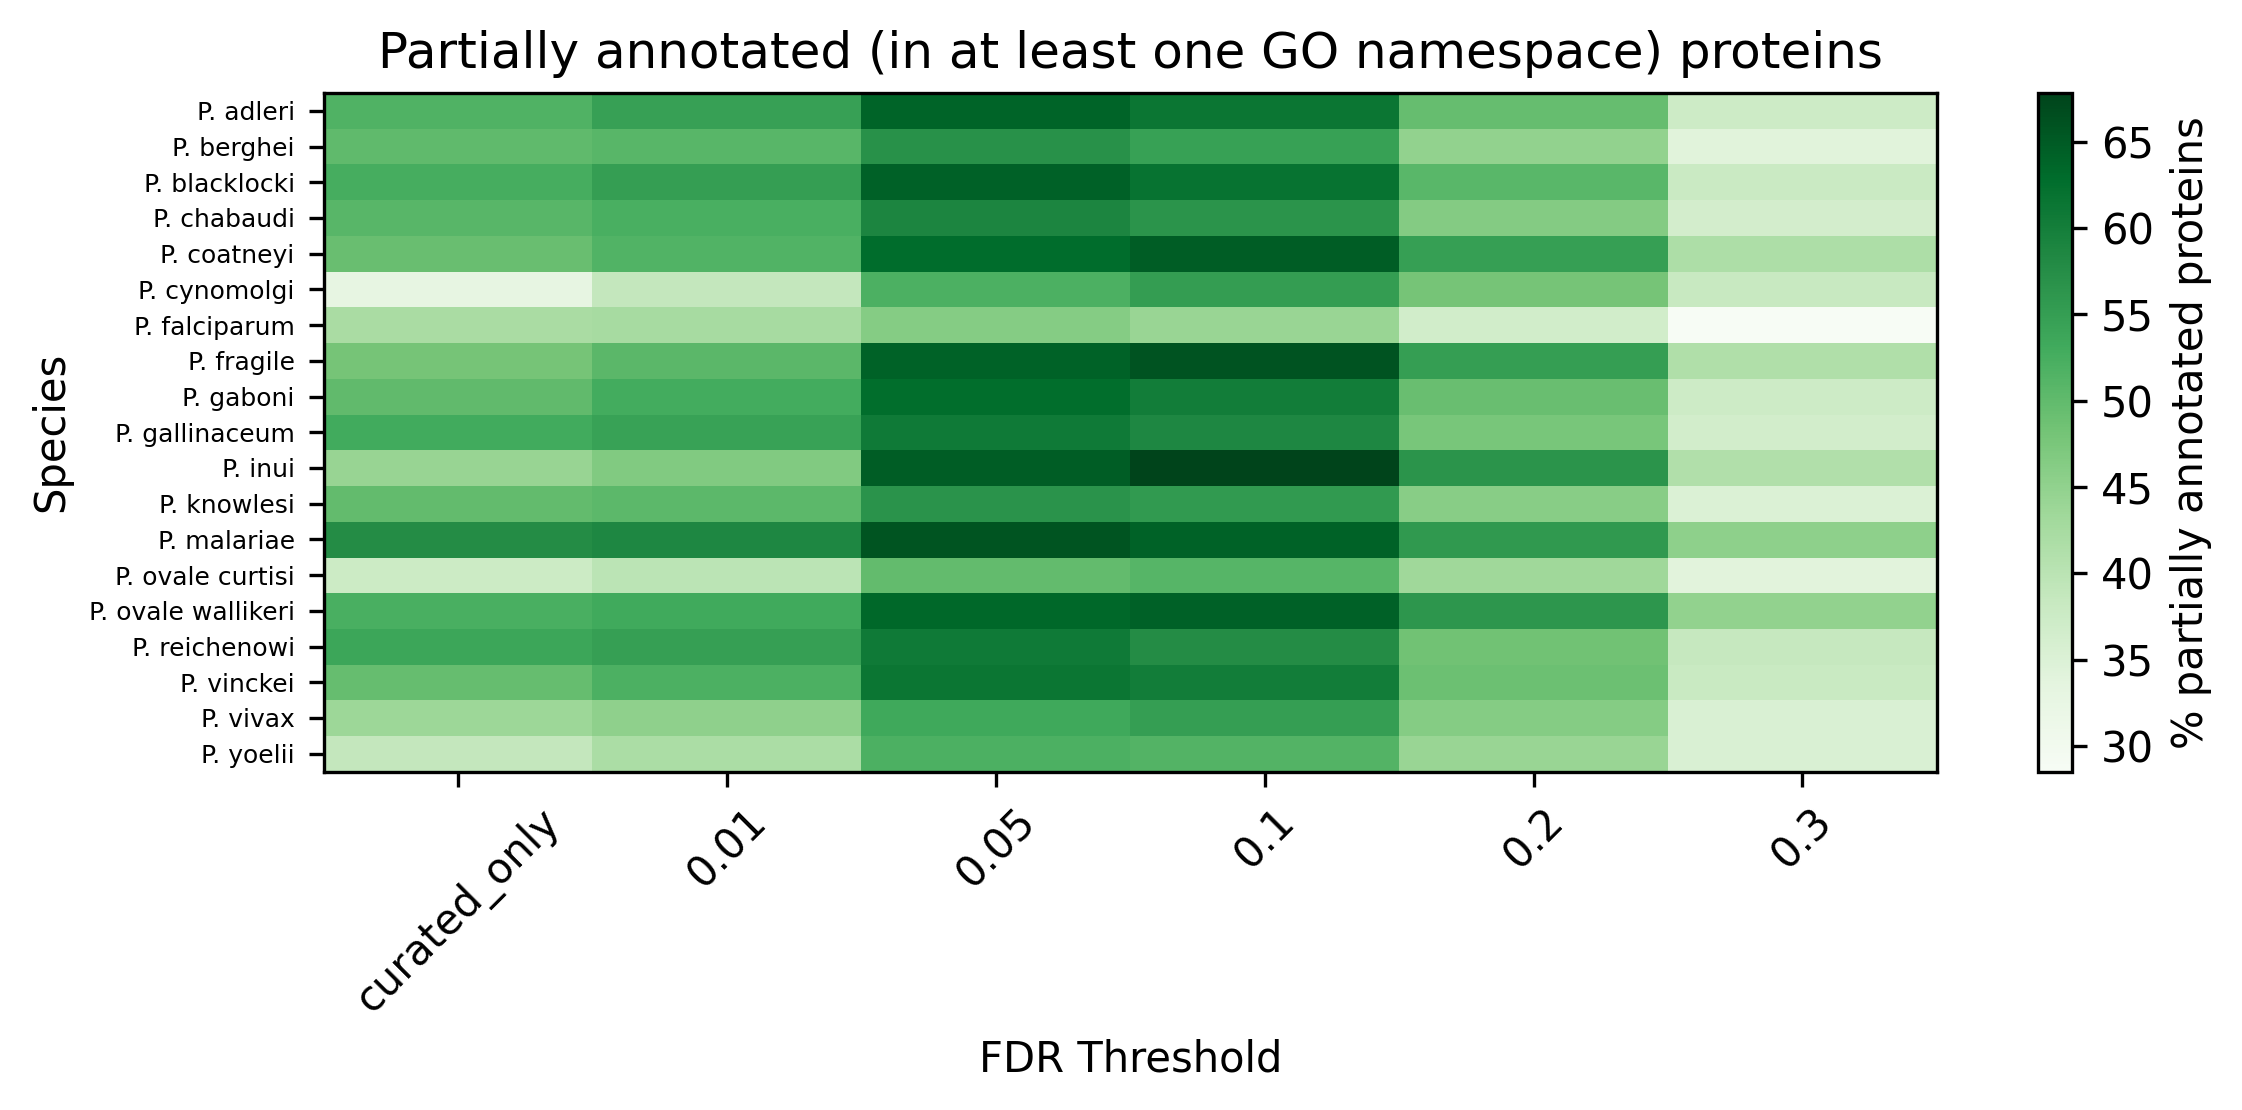

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_pct = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_fully=lambda d: d['fully_annotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_fully')
)

ordered_cols = sorted(df_pct.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_pct = df_pct[ordered_cols]

fig, ax = plt.subplots(figsize=(8, len(df_pct)*0.2))
im = ax.imshow(df_pct, aspect='auto', origin='lower', cmap='Blues')
fig.dpi = 300
df_pct.index = df_pct.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_pct.index)))
ax.set_yticklabels(df_pct.index, fontsize=6)
ax.set_xticks(np.arange(len(df_pct.columns)))
x_labels = ['Existing in\nPlasmoDB', '1%','5%', '10%', '20%', '30%']
ax.set_xticklabels(x_labels, rotation=45)

ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% fully annotated')
ax.invert_yaxis()

ax.set_title('Annotated (in all three GO namespaces) proteins')
fig.tight_layout()
plt.show()


df_unann = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_unannotated=lambda d: d['unannotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_unannotated')
)

ordered_cols = sorted(df_unann.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_unann = df_unann[ordered_cols]

fig, ax = plt.subplots(figsize=(8, len(df_unann)*0.2))
im = ax.imshow(df_unann, aspect='auto', origin='lower', cmap='Reds')
fig.dpi = 300

df_unann.index = df_unann.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_unann.index)))
ax.set_yticklabels(df_unann.index, fontsize=6)
ax.set_xticks(np.arange(len(df_unann.columns)))
ax.set_xticklabels([str(c) for c in df_unann.columns], rotation=45)

ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
ax.invert_yaxis()

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% unannotated proteins')
ax.set_title('Unannotated (in all three GO namespaces) proteins')

fig.tight_layout()
plt.show()


df_partial = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_partial=lambda d: d['partially_annotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_partial')
)

ordered_cols = sorted(df_partial.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_partial = df_partial[ordered_cols]

fig, ax = plt.subplots(figsize=(8, len(df_partial)*0.2))
im = ax.imshow(df_partial, aspect='auto', origin='lower', cmap='Greens')
fig.dpi = 300

df_partial.index = df_partial.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_partial.index)))
ax.set_yticklabels(df_partial.index, fontsize=6)
ax.set_xticks(np.arange(len(df_partial.columns)))
ax.set_xticklabels([str(c) for c in df_partial.columns], rotation=45)
ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
ax.invert_yaxis()

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% partially annotated proteins')
ax.set_title('Partially annotated (in at least one GO namespace) proteins')
fig.tight_layout()
plt.show()


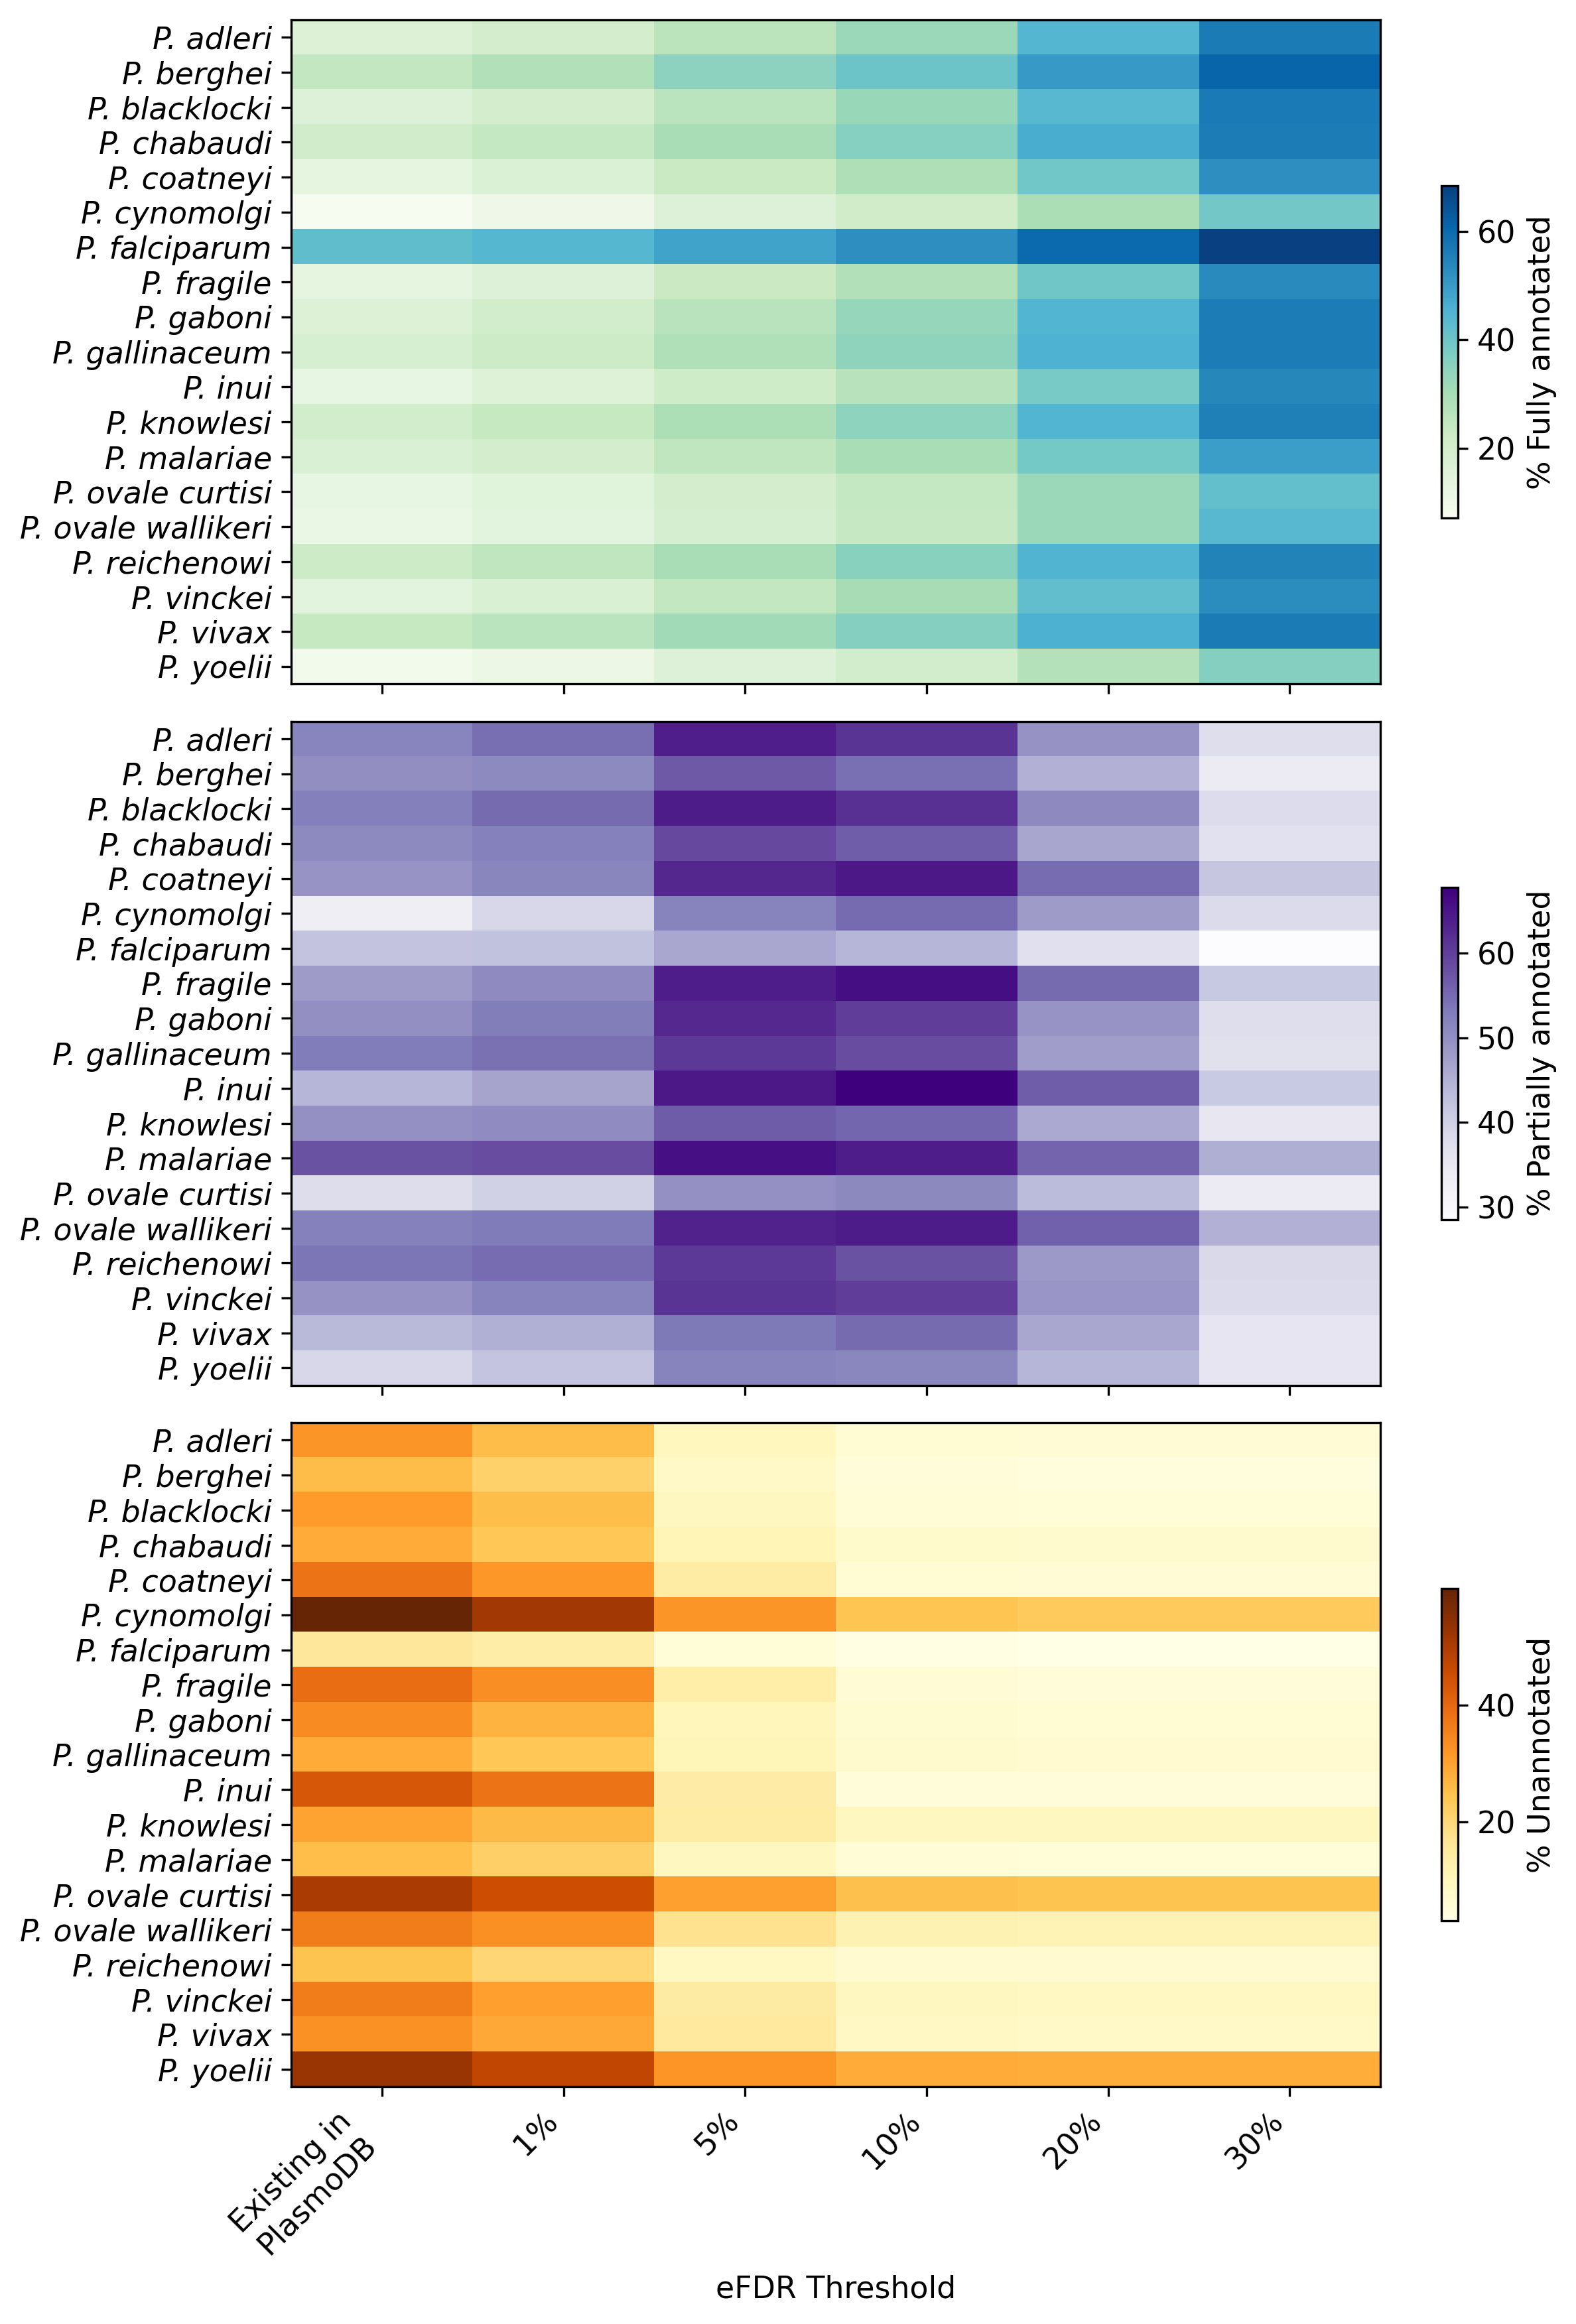

In [ ]:
for df in (df_pct, df_partial, df_unann):
    df.index = [ species_to_name.get(s, s) for s in df.index ]


plots = [
    (df_pct,    'GnBu',  'Annotated',      '% Fully annotated'),
    (df_partial,'Purples', 'Partially annotated', '% Partially annotated'),
    (df_unann,  'YlOrBr',   'Unannotated',  '% Unannotated'),
]


fig, axes = plt.subplots(nrows=3, ncols=1,
                         figsize=(8, len(df_pct)*0.2*3.1),  # stack 3 panels
                         sharex=True)
fig.dpi = 300

for ax, (df_metric, cmap, title, cbar_label) in zip(axes, plots):
    im = ax.imshow(df_metric, aspect='auto', origin='lower', cmap=cmap)
    # ax.set_title(title, fontsize=11, pad=6)

    ax.set_yticks(np.arange(len(df_metric.index)))
    ax.set_yticklabels(df_metric.index, fontsize=11, fontstyle = 'italic')

    if ax is axes[-1]:
        ax.set_xticks(np.arange(len(df_metric.columns)))
        ax.set_xticklabels(['Existing in\nPlasmoDB','1%','5%','10%','20%','30%'],
                            rotation=45, ha='right', fontsize=11)
        ax.set_xlabel('eFDR Threshold', fontsize=11)
    else:
        ax.tick_params(labelbottom=False)

    ax.invert_yaxis()

    cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, orientation='vertical', shrink=0.5)
    cbar.ax.tick_params(labelsize=11)
    cbar.ax.set_ylabel(cbar_label, fontsize=11)

fig.tight_layout(h_pad=1.0)
plt.show()


In [53]:
df_pct

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,16.375587,19.699531,26.084507,32.356808,44.281690,56.413146
P. berghei,24.223477,27.773296,34.691408,40.278338,50.282372,60.972166
P. blacklocki,16.235294,19.823529,26.294118,32.568627,43.803922,56.686275
P. chabaudi,20.696288,24.081554,30.063474,36.045393,46.374303,56.241585
P. coatneyi,13.161711,16.660624,23.078318,28.843365,39.213198,52.393038
P. cynomolgi,7.234674,10.085695,16.150297,20.896506,29.268293,39.024390
P. falciparum,42.271293,43.997031,48.320653,52.477269,60.159584,68.324364
P. fragile,12.905501,16.290550,22.514104,28.085331,39.615656,53.385049
P. gaboni,16.497857,20.023374,26.762758,33.229451,44.487729,56.388781
P. gallinaceum,18.444949,21.944760,28.414680,34.298146,45.289444,56.337495


In [34]:
df_partial

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,51.605634,54.647887,63.962441,61.239437,49.521127,37.389671
P. berghei,50.161355,50.887455,56.918112,54.558290,44.796289,34.106495
P. blacklocki,52.529412,55.058824,64.274510,61.745098,50.725490,37.843137
P. chabaudi,50.894403,52.298519,58.876707,56.491633,46.355068,36.487786
P. coatneyi,49.111675,51.432197,62.799130,64.738941,54.804206,41.624365
P. cynomolgi,32.943309,38.661833,51.862228,55.075808,47.874094,38.117996
P. falciparum,42.030061,42.382631,46.223789,44.145482,36.685842,28.521061
P. fragile,47.990127,50.599436,64.051481,65.937941,55.059944,41.290550
P. gaboni,49.883132,52.902220,62.738605,60.264901,49.201402,37.300351
P. gallinaceum,53.045781,54.388952,60.745365,58.475218,47.692017,36.643965


In [35]:
df_unann

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,32.018779,25.652582,9.953052,6.403756,6.197183,6.197183
P. berghei,25.615167,21.339250,8.390480,5.163372,4.921339,4.921339
P. blacklocki,31.235294,25.117647,9.431373,5.686275,5.470588,5.470588
P. chabaudi,28.409309,23.619927,11.059819,7.462974,7.270629,7.270629
P. coatneyi,37.726613,31.907179,14.122553,6.417694,5.982596,5.982596
P. cynomolgi,59.822017,51.252472,31.987475,24.027686,22.857614,22.857614
P. falciparum,15.698645,13.620338,5.455558,3.377250,3.154574,3.154574
P. fragile,39.104372,33.110014,13.434415,5.976728,5.324401,5.324401
P. gaboni,33.619011,27.074406,10.498637,6.505649,6.310869,6.310869
P. gallinaceum,28.509270,23.666288,10.839955,7.226636,7.018540,7.018540


In [54]:
#save to dfs 
df_pct.to_csv("annotation_stats/annotation_stats_full_FINAL_3.tsv", sep="\t")
df_partial.to_csv("annotation_stats/annotation_stats_partial_FINAL_3.tsv", sep="\t")
df_unann.to_csv("annotation_stats/annotation_stats_unann_FINAL_3.tsv", sep="\t")

In [ ]:
average_pct_fully = df_pct['curated_only'].mean()
average_pct_unannotated = df_unann['curated_only'].mean()

average_pct_fully_0_3 = df_pct[0.3].mean()
average_pct_unannotated_0_3 = df_unann[0.3].mean()
print(f"Average % fully annotated at curated_only: {average_pct_fully:.2f}%")
print(f"Average % unannotated at curated_only: {average_pct_unannotated:.2f}%")
print(f"Average % fully annotated at 0.3: {average_pct_fully_0_3:.2f}%")
print(f"Average % unannotated at 0.3: {average_pct_unannotated_0_3:.2f}%")

print("The difference in average % fully annotated between curated_only and 0.3 is: "
      f"{average_pct_fully_0_3 - average_pct_fully:.2f}%")
print("The difference in average % unannotated between curated_only and 0.3 is: "
      f"{average_pct_unannotated_0_3 - average_pct_unannotated:.2f}%")python query_go_terms_enhanced.pypython query_go_terms_enhanced.pypython query_go_terms_enhanced.pypython query_go_terms_enhanced.pypython query_go_terms_enhanced.pypython query_pypsdfasdfimport import imporimroijadsfajsdfimimimimimimimrrwerwerwerwersdfsdfsdfsfsdfdfdfdfdfTadfadfasdfasdfasdfasdfasdfasdfasdf

Average % fully annotated at curated_only: 17.35%
Average % unannotated at curated_only: 34.89%
Average % fully annotated at 0.3: 52.68%
Average % unannotated at 0.3: 9.60%
The difference in average % fully annotated between curated_only and 0.3 is: 35.32%
The difference in average % unannotated between curated_only and 0.3 is: -25.30%


In [ ]:
average_pct_fully = df_pct['curated_only'].mean()
average_pct_unannotated = df_unann['curated_only'].mean()

average_pct_fully_0_3 = df_pct[0.3].mean()
average_pct_unannotated_0_3 = df_unann[0.3].mean()
print(f"Average % fully annotated at curated_only: {average_pct_fully:.2f}%")
print(f"Average % unannotated at curated_only: {average_pct_unannotated:.2f}%")
print(f"Average % fully annotated at 0.3: {average_pct_fully_0_3:.2f}%")
print(f"Average % unannotated at 0.3: {average_pct_unannotated_0_3:.2f}%")

print("The difference in average % fully annotated between curated_only and 0.3 is: "
      f"{average_pct_fully_0_3 - average_pct_fully:.2f}%")
print("The difference in average % unannotated between curated_only and 0.3 is: "
      f"{average_pct_unannotated_0_3 - average_pct_unannotated:.2f}%")

Average % fully annotated at curated_only: 17.35%
Average % unannotated at curated_only: 34.89%
Average % fully annotated at 0.3: 52.68%
Average % unannotated at 0.3: 9.60%
The difference in average % fully annotated between curated_only and 0.3 is: 35.32%
The difference in average % unannotated between curated_only and 0.3 is: -25.30%


In [ ]:
df_pct_diff = df_pct['curated_only'] - df_pct[0.3]
df_pct_diff_sorted = df_pct_diff.sort_values(ascending=False)
df_pct_diff_sorted

P. falciparum        -26.053071
P. yoelii            -27.586207
P. ovale curtisi     -29.410883
P. cynomolgi         -31.789717
P. ovale wallikeri   -32.193320
P. malariae          -32.497476
P. vivax             -32.875226
P. reichenowi        -32.918056
P. knowlesi          -35.172673
P. chabaudi          -35.545297
P. berghei           -36.748689
P. gallinaceum       -37.892546
P. vinckei           -38.928230
P. coatneyi          -39.231327
P. gaboni            -39.890923
P. adleri            -40.037559
P. blacklocki        -40.450980
P. fragile           -40.479549
P. inui              -41.460905
dtype: float64

In [ ]:
df_unann_diff = df_unann['curated_only'] - df_unann[0.3]
df_unann_diff_sorted = df_unann_diff.sort_values(ascending=False)
print(df_unann_diff_sorted)
#print range 
print(f"Range of df_unann_diff: {df_unann_diff.min()} to {df_unann_diff.max()}")

P. inui               38.477366
P. cynomolgi          36.964403
P. fragile            33.779972
P. coatneyi           31.744017
P. vinckei            27.387560
P. gaboni             27.308142
P. adleri             25.821596
P. ovale curtisi      25.798231
P. blacklocki         25.764706
P. ovale wallikeri    24.903661
P. vivax              24.575045
P. yoelii             24.308216
P. gallinaceum        21.490730
P. chabaudi           21.138681
P. berghei            20.693828
P. knowlesi           20.514264
P. malariae           19.976439
P. reichenowi         17.476750
P. falciparum         12.544071
dtype: float64
Range of df_unann_diff: 12.544071256262756 to 38.477366255144034


In [59]:
print(f"Range of df_annnotated : {df_pct[0.3].min()} to {df_pct[0.3].max()}")

Range of df_annnotated : 36.3417056903647 to 68.3243644460939


In [ ]:
ontology_map = {
    'MF': ('GO Function', 'GO IEA Function', 'PFP MF'),
    'BP': ('GO Process', 'GO IEA Process', 'PFP BP'),
    'CC': ('GO Component', 'GO IEA Component', 'PFP CC'),
}
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]

records_ontology = []

for species, genes in gene_dicts.items():
    total_genes = len(genes)
    for ont, (cur_key, iea_key, pfp_key) in ontology_map.items():

        annotated = sum(bool(annot.get(cur_key, []) or annot.get(iea_key, []))
                        for annot in genes.values())
        unannotated = total_genes - annotated
        records_ontology.append({
            'species': species,
            'ontology': ont,
            'threshold': 'curated_only',
            'unannotated': unannotated,
            'annotated': annotated
        })

        for t in thresholds:
            annotated_t = 0
            for annot in genes.values():
                curated_any = bool(annot.get(cur_key, []) or annot.get(iea_key, []))
                pfp_preds = annot.get(pfp_key, {}).get(t, set())
                if curated_any or pfp_preds:
                    annotated_t += 1
            unannotated_t = total_genes - annotated_t
            records_ontology.append({
                'species': species,
                'ontology': ont,
                'threshold': t,
                'unannotated': unannotated_t,
                'annotated': annotated_t
            })

df_per_ontology = pd.DataFrame(records_ontology)
df_per_ontology = df_per_ontology.set_index(['species', 'ontology', 'threshold'])
df_per_ontology.to_csv("annotation_stats/annotation_stats_per_ontology_FINAL_3.tsv", sep="\t")
df_per_ontology


unannotated  \
species                            ontology threshold                   
PlasmoDB-68_PinuiSanAntonio1       MF       curated_only         3720   
                                            0.01                 3207   
                                            0.05                 1366   
                                            0.1                   505   
                                            0.2                   433   
...                                                               ...   
PlasmoDB-68_PvinckeibrucechwattiDA CC       0.01                 3095   
                                            0.05                 2744   
                                            0.1                  2439   
                                            0.2                  1834   
                                            0.3                  1416   

                                                          annotated  
species                            ontology threshold                
PlasmoDB-68_PinuiSanAntonio1       MF       curated_only       2112  
                                            0.01               2625  
                                            0.05               4466  
                                            0.1                5327  
                                            0.2                5399  
...                                                             ...  
PlasmoDB-68_PvinckeibrucechwattiDA CC       0.01               2130  
                                            0.05               2481  
                                            0.1                2786  
                                            0.2                3391  
                                            0.3                3809  

[342 rows x 2 columns]